In [1]:
import numpy as np
from sympy.utilities.iterables import multiset_permutations
import time
import pandas as pd
import gurobipy as grb
import datetime
import random
np.set_printoptions(edgeitems=15,linewidth=600)

%load_ext autoreload
%autoreload 2
import sys
import os
sys.path.append(os.path.join(os.getcwd(), '..'))
from src.optimization.MIP.mip_inputs import *
from src.optimization.MIP.mip_model import *
from src.optimization.MIP.mip_outputs import *

In [2]:
start = time.time()

### Model Inputs 

In [3]:
UI_params = {
    'initial_procurement_budget':1300000,
    'procurement_budget_rate':0.03,
    'initial_operations_budget':1000000,
    'maintenance_budget_rate':0.03,
    'planning_interval':[2022,2037],
    'emissions_baseline': 2031705,#metric tons
    'emissions_target_pct_of_base':0.10,
    'min_miles_replacement_threshold':150000,#miles
    'min_vehicle_age_replacement_threshold':60,#years
    'max_vehicles_per_station':1000,
    'objective_weights':{'cost':0.70,'emissions':0.30},
}

In [25]:
data = pd.read_excel('../data/17MAR_data_template.xlsx')#.head(250)
data['current_age'] = datetime.datetime.now().year - pd.to_datetime(data.purchasedate).dt.year
data = data.reset_index().rename({"index":"vehicle_idx"},axis=1)
data['county'] = 'Baltimore County'
data = data.drop_duplicates('equipmentid')
data = data[data.vehicle_idx<1458]

In [34]:
inputs = MIP_Inputs(data,UI_params)

In [35]:
outputs = MIP_Outputs(data,UI_params)
print("--- %s seconds ---" % (time.time() - start))

Changed value of parameter PoolSearchMode to 2
   Prev: 0  Min: 0  Max: 2  Default: 0
Changed value of parameter PoolSolutions to 500
   Prev: 10  Min: 1  Max: 2000000000  Default: 10
Changed value of parameter TimeLimit to 30.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Gurobi Optimizer version 9.0.3 build v9.0.3rc0 (win64)
Optimize a model with 1491 rows, 95386 columns and 1798177 nonzeros
Model fingerprint: 0x5e9d6e32
Variable types: 2 continuous, 95384 integer (95384 binary)
Coefficient statistics:
  Matrix range     [1e+00, 6e+05]
  Objective range  [1e+01, 1e+06]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+06]
Found heuristic solution: objective 1.445882e+13
Presolve added 15 rows and 104 columns
Presolve time: 4.28s
Presolved: 1506 rows, 95490 columns, 1733449 nonzeros
Variable types: 91 continuous, 95399 integer (95394 binary)

Root simplex log...

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    3.0885120e+05   1.024650e+05   

In [36]:
optimal_obj,optimal_solution = outputs.get_optimal_solution()

In [37]:
alt_solutions = outputs.get_alternative_solutions()
selected_alternative_solutions = outputs.select_alternative_solutions(alt_solutions,optimal_obj)

In [38]:
options = selected_alternative_solutions

In [39]:
option1 = pd.DataFrame(options[0,'schedules'],columns=['vehicle_idx','solution_idx']+inputs.years)

In [40]:
data = data.merge(option1,on='vehicle_idx',how='left')

In [41]:
data.groupby(['county'])[inputs.years].sum().replace({0:''})

,2022,2023,2024,2025,2026,2027,2028,2029,2030,2031,2032,2033,2034,2035,2036,2037
county,,,,,,,,,,,,,,,,
Baltimore County,111,93,89,89,85,91,92,108,89,89,83,84,60,59,81,56


In [60]:
data.groupby(['dept_name'])[inputs.years].sum().replace({0:''}).head()

,2022,2023,2024,2025,2026,2027,2028,2029,2030,2031,2032,2033,2034,2035,2036,2037
dept_name,,,,,,,,,,,,,,,,
Baltimore County Department of Library,,,,,,,,,,1,1,,,,,
Board of Election Supervisors,,,,,,,,,,,1,,,,,
Bureau of Corrections,,,,,,,1,1,2,3,1,1,,1,,
Cigarette Restoration/Tobacco Program,,,,,,,,,,,1,,,,,
Community Planning,,,,,,,,,,,,,,1,,


In [59]:
data.groupby(['dept_name','vehicledescription'])[inputs.years].sum().replace({0:''}).head(20)

2022  \
dept_name                              vehicledescription                     
Baltimore County Department of Library 2002 FORD VAN CARGO'                   
                                       2019 DODGE Grand Caravan'              
Board of Election Supervisors          2008 CHEVROLET UPLANDER'               
Bureau of Corrections                  2001 GMC VAN 12PSG'                    
                                       2005 FORD CROWN VICTORIA'              
                                       2006 CHEVROLET VAN,PRISONER TP'        
                                       2006 FORD CROWN VICTORIA'              
                                       2007 CHEVROLET VAN,PRISONER TP'        
                                       2008 FORD CROWN VICTORIA'              
                                       2009 FORD CROWN VICTORIA'              
                                       2010 CHEVROLET VAN 12PSG'              
                                       2019 DODGE Grand Caravan'              
Cigarette Restoration/Tobacco Program  2009 HONDA CIVIC'                      
Community Planning                     2006 GMC SAVANA'                       
County Council                         2008 CHEVROLET IMPALA'                 
                                       2014 FORD FUSION'                      
                                       2017 JEEP CHEROKEE'                    
                                       2018 CHEVROLET IMPALA'                 
County Sheriff                         2005 CHEVROLET VAN,PRISONER TP'        
                                       2006 CHEVROLET VAN,PRISONER TP'        

                                                                       2023  \
dept_name                              vehicledescription                     
Baltimore County Department of Library 2002 FORD VAN CARGO'                   
                                       2019 DODGE Grand Caravan'              
Board of Election Supervisors          2008 CHEVROLET UPLANDER'               
Bureau of Corrections                  2001 GMC VAN 12PSG'                    
                                       2005 FORD CROWN VICTORIA'              
                                       2006 CHEVROLET VAN,PRISONER TP'        
                                       2006 FORD CROWN VICTORIA'              
                                       2007 CHEVROLET VAN,PRISONER TP'        
                                       2008 FORD CROWN VICTORIA'              
                                       2009 FORD CROWN VICTORIA'              
                                       2010 CHEVROLET VAN 12PSG'              
                                       2019 DODGE Grand Caravan'              
Cigarette Restoration/Tobacco Program  2009 HONDA CIVIC'                      
Community Planning                     2006 GMC SAVANA'                       
County Council                         2008 CHEVROLET IMPALA'                 
                                       2014 FORD FUSION'                      
                                       2017 JEEP CHEROKEE'                    
                                       2018 CHEVROLET IMPALA'                 
County Sheriff                         2005 CHEVROLET VAN,PRISONER TP'        
                                       2006 CHEVROLET VAN,PRISONER TP'        

                                                                       2024  \
dept_name                              vehicledescription                     
Baltimore County Department of Library 2002 FORD VAN CARGO'                   
                                       2019 DODGE Grand Caravan'              
Board of Election Supervisors          2008 CHEVROLET UPLANDER'               
Bureau of Corrections                  2001 GMC VAN 12PSG'                    
                                       2005 FORD CROWN VICTORIA'              
                                       2

In [76]:
builtins.PyCapsule

AttributeError: module 'builtins' has no attribute 'PyCapsule'

In [66]:
data.groupby(['equipmentid'])[inputs.years].sum().replace({0:''}).sample(20)

,2022,2023,2024,2025,2026,2027,2028,2029,2030,2031,2032,2033,2034,2035,2036,2037
equipmentid,,,,,,,,,,,,,,,,
30731.0,,,,,1,,,,,,,,,,,
27834.0,,,,,,,,,,1,,,,,,
30869.0,,,,,,,,,,,,,,1,,
27956.0,,,,,,,,1,,,,,,,,
31615.0,,,,,,,,,,,,1,,,,
27872.0,,,,,,,,1,,,,,,,,
27859.0,,,,1,,,,,,,,,,,,
31260.0,,,1,,,,,,,,,,,,,
30907.0,,,,1,,,,,,,,,,,,


In [45]:
print('   acquisition_costs')
pd.DataFrame(pd.DataFrame(options[0,'acquisition_costs'],columns=['vehicle_idx','solution_idx']+inputs.years)[inputs.years].sum()).T.astype(int)

   acquisition_costs


,2022,2023,2024,2025,2026,2027,2028,2029,2030,2031,2032,2033,2034,2035,2036,2037
0,4508000,3767800,3742500,3716300,3749900,3745000,3786000,4453000,3748800,3736200,3737200,3767300,3786900,3692900,4448500,3685300


In [46]:
print('   consumables_costs')
pd.DataFrame(pd.DataFrame(options[0,'consumables_costs'],columns=['vehicle_idx','solution_idx']+inputs.years)[inputs.years].sum()).T.astype(int)

   consumables_costs


,2022,2023,2024,2025,2026,2027,2028,2029,2030,2031,2032,2033,2034,2035,2036,2037
0,2092277,1871742,1720808,1596987,1486370,1396065,1321963,1261161,1211574,1170112,1137951,1113064,1093945,1080024,1071359,1066907


In [47]:
print('   mx_costs')
pd.DataFrame(pd.DataFrame(options[0,'mx_costs'],columns=['vehicle_idx','solution_idx']+inputs.years)[inputs.years].sum()).T.astype(int)

   mx_costs


,2022,2023,2024,2025,2026,2027,2028,2029,2030,2031,2032,2033,2034,2035,2036,2037
0,1383000,1401600,1398400,1380200,1338200,1331600,1319000,1278200,1262800,1242800,1212200,1194800,1163800,1145000,1149400,1125400


In [48]:
print('   emissions_amts')
pd.DataFrame(pd.DataFrame(options[0,'emissions_amts'],columns=['vehicle_idx','solution_idx']+inputs.years)[inputs.years].sum()).T.astype(int)

   emissions_amts


,2022,2023,2024,2025,2026,2027,2028,2029,2030,2031,2032,2033,2034,2035,2036,2037
0,2057189,1766625,1552630,1370334,1193288,1034823,910045,800190,716344,633872,566229,491286,430366,345694,246455,190714


In [64]:
print('   EV/Hybrid Inventory')
ev_inv = pd.DataFrame(pd.DataFrame(options[0,'conversions'],columns=['vehicle_idx','solution_idx']+inputs.years)[inputs.years].sum())
ev_inv.columns = ['EV']
ev_inv.EV = ev_inv.EV
ev_inv['ICE'] = inputs.num_vehicles-ev_inv.EV
# ev_inv.melt(value_vars=['EV','ICE'],ignore_index=False)

   EV/Hybrid Inventory


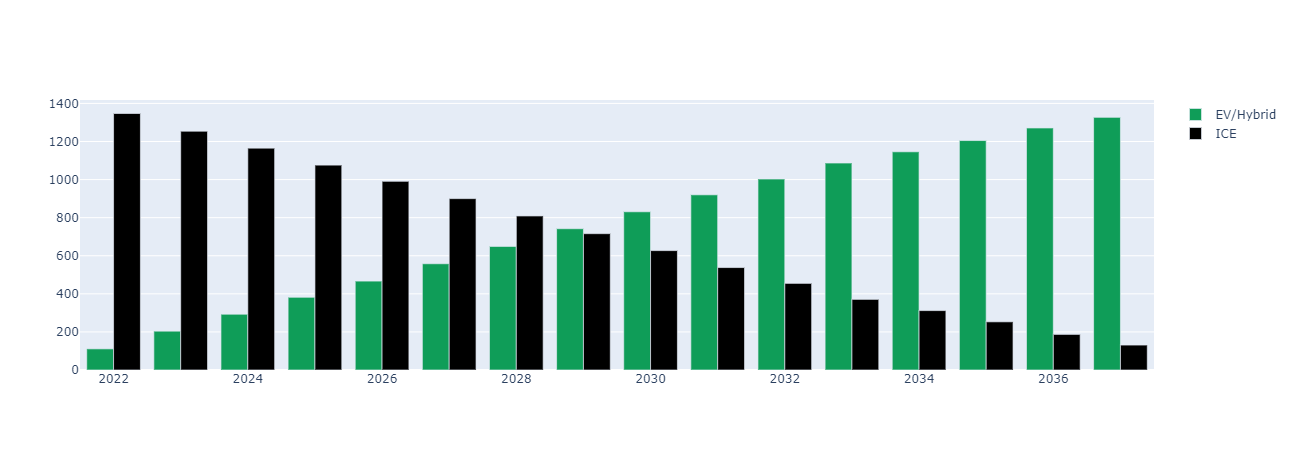

In [50]:
import plotly.graph_objects as go



fig = go.Figure()
fig.add_trace(go.Bar(x=inputs.years,
                y=ev_inv.EV,
                name='EV/Hybrid',
                marker_color='rgb(15,157,88)'
                ))
fig.add_trace(go.Bar(x=inputs.years,
                y=ev_inv.ICE,
                name='ICE',
                marker_color='rgb(0,0,0)'
                ))


In [51]:
ev_inv/inputs.num_vehicles

,EV,ICE
2022,0.076132,0.923868
2023,0.139918,0.860082
2024,0.200960,0.799040
2025,0.262003,0.737997
2026,0.320302,0.679698
2027,0.382716,0.617284
2028,0.445130,0.554870
2029,0.508916,0.491084
2030,0.569959,0.430041
2031,0.631001,0.368999


In [52]:
inputs.num_vehicles

1458